# Predicting Medical Appointment No-Shows
Data from [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments/home)

In [1]:
# Imports
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

%matplotlib inline
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Helper functions
def unique_col_values(df):
    max_name_len = np.max([len(col_name) for col_name in raw_data.columns]) + 2
    format_str = "{:<" + str(max_name_len) + "}{:<8}{:<15}"

    print(format_str.format("Name", "Unique", "DType"))
    print()
    for col in df:
        print(format_str.format(df[col].name, len(df[col].unique()), str(df[col].dtype)))

def convert_to_category(df, cols):
    for col in cols:
        df[col] = df[col].astype("category")

## Data exploration and initial cleaning

In [3]:
# Import the data
raw_data = pd.read_csv("KaggleV2-May-2016.csv")
print("Rows: {}\nColumns: {}".format(raw_data.shape[0], raw_data.shape[1]))

# Clean up column names
raw_data.columns = ["patient_id", "appointment_id", "gender", "scheduled_day",
                   "appointment_day", "age", "neighborhood", "scholarship",
                    "hypertension", "diabetes", "alcoholism", "handicap", "sms_received",
                   "no_show"]
raw_data.head()

Rows: 110527
Columns: 14


,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
# Get data details
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
patient_id         110527 non-null float64
appointment_id     110527 non-null int64
gender             110527 non-null object
scheduled_day      110527 non-null object
appointment_day    110527 non-null object
age                110527 non-null int64
neighborhood       110527 non-null object
scholarship        110527 non-null int64
hypertension       110527 non-null int64
diabetes           110527 non-null int64
alcoholism         110527 non-null int64
handicap           110527 non-null int64
sms_received       110527 non-null int64
no_show            110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [5]:
# Check for missing values
raw_data.isnull().sum()

patient_id         0
appointment_id     0
gender             0
scheduled_day      0
appointment_day    0
age                0
neighborhood       0
scholarship        0
hypertension       0
diabetes           0
alcoholism         0
handicap           0
sms_received       0
no_show            0
dtype: int64

In [6]:
# Check for duplicates using the appointment unique identifier column
raw_data.duplicated("appointment_id").sum()

0

In [7]:
# Drop columns we will not need
raw_data.drop(["patient_id", "appointment_id"], axis=1, inplace=True)

# Convert scheduled_day and appointment_day to datetime format
raw_data["scheduled_day"] = pd.to_datetime(raw_data["scheduled_day"])
raw_data["appointment_day"] = pd.to_datetime(raw_data["appointment_day"])

# Convert qualitative columns to category type
convert_to_category(raw_data, ["gender", "neighborhood", "scholarship", "hypertension",
                              "diabetes", "alcoholism", "handicap", "sms_received", "no_show"])
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 12 columns):
gender             110527 non-null category
scheduled_day      110527 non-null datetime64[ns]
appointment_day    110527 non-null datetime64[ns]
age                110527 non-null int64
neighborhood       110527 non-null category
scholarship        110527 non-null category
hypertension       110527 non-null category
diabetes           110527 non-null category
alcoholism         110527 non-null category
handicap           110527 non-null category
sms_received       110527 non-null category
no_show            110527 non-null category
dtypes: category(9), datetime64[ns](2), int64(1)
memory usage: 3.5 MB


In [8]:
unique_col_values(raw_data)

Name             Unique  DType          

gender           2       category       
scheduled_day    103549  datetime64[ns] 
appointment_day  27      datetime64[ns] 
age              104     int64          
neighborhood     81      category       
scholarship      2       category       
hypertension     2       category       
diabetes         2       category       
alcoholism       2       category       
handicap         5       category       
sms_received     2       category       
no_show          2       category       


### Univariate exploration

In [9]:
raw_data["gender"].describe()

count     110527
unique         2
top            F
freq       71840
Name: gender, dtype: object

In [10]:
raw_data["gender"].value_counts()

F    71840
M    38687
Name: gender, dtype: int64

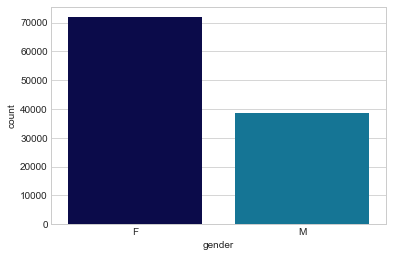

In [11]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="gender", data=raw_data, palette="ocean")
plt.show()

In [12]:
raw_data["scheduled_day"].describe()

count                  110527
unique                 103549
top       2016-05-06 07:09:54
freq                       24
first     2015-11-10 07:13:56
last      2016-06-08 20:07:23
Name: scheduled_day, dtype: object

In [13]:
raw_data["appointment_day"].describe()

count                  110527
unique                     27
top       2016-06-06 00:00:00
freq                     4692
first     2016-04-29 00:00:00
last      2016-06-08 00:00:00
Name: appointment_day, dtype: object

In [14]:
def calc_time_between(cols):
    appointment_day = cols[0]
    scheduled_day = cols[1]
    return (appointment_day.date() - scheduled_day.date()).days

raw_data["scheduled_to_appointment"] = raw_data[["appointment_day", "scheduled_day"]].apply(calc_time_between, axis=1)

raw_data["scheduled_to_appointment"].describe()

count    110527.000000
mean         10.183702
std          15.254996
min          -6.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: scheduled_to_appointment, dtype: float64

In [15]:
print("Number of scheduled_to_appointment less than 0: {}".format(len(raw_data[raw_data["scheduled_to_appointment"] < 0])))

# Drop observations with scheduled_to_appointment < 0
raw_data = raw_data[raw_data["scheduled_to_appointment"] >= 0]

Number of scheduled_to_appointment less than 0: 5


In [16]:
raw_data["scheduled_to_appointment"].describe()

count    110522.000000
mean         10.184253
std          15.255115
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: scheduled_to_appointment, dtype: float64

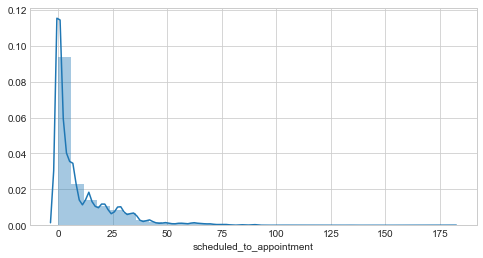

In [17]:
fig = plt.figure(figsize=(8, 4))
sns.distplot(raw_data["scheduled_to_appointment"], bins=30)
plt.show()

In [18]:
def get_weekday(date):
    weekday_codes = {0: "monday", 1: "tuesday",
                    2: "wednesday", 3: "thursday",
                    4: "friday", 5: "saturday",
                    6: "sunday"}
    return weekday_codes[date.weekday()]

raw_data["appointment_weekday"] = raw_data["appointment_day"].apply(lambda x: get_weekday(x)).astype("category")
raw_data["appointment_weekday"].describe()

count        110522
unique            6
top       wednesday
freq          25866
Name: appointment_weekday, dtype: object

In [19]:
raw_data["appointment_weekday"].value_counts()

wednesday    25866
tuesday      25638
monday       22714
friday       19019
thursday     17246
saturday        39
Name: appointment_weekday, dtype: int64

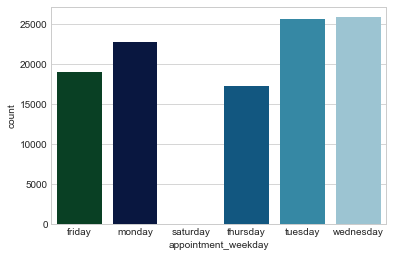

In [20]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="appointment_weekday", data=raw_data, palette="ocean")
plt.show()

In [21]:
raw_data["age"].describe()

count    110522.000000
mean         37.089041
std          23.110064
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: age, dtype: float64

In [22]:
# Drop values below zero and equal 115
raw_data = raw_data[(raw_data["age"] >= 0) & (raw_data["age"] != 115)]
print("Rows: {}\nColumns: {}".format(raw_data.shape[0], raw_data.shape[1]))
raw_data["age"].describe()

Rows: 110516
Columns: 14


count    110516.000000
mean         37.085861
std          23.104465
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         102.000000
Name: age, dtype: float64

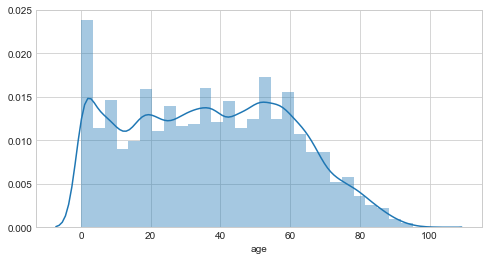

In [23]:
fig = plt.figure(figsize=(8, 4))
sns.distplot(raw_data["age"], bins=30)
plt.show()

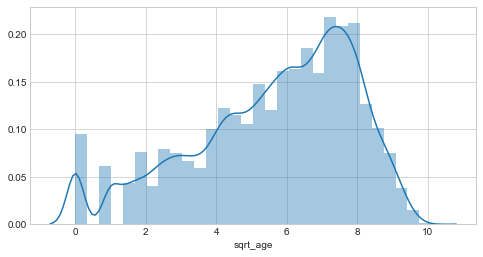

In [24]:
raw_data["sqrt_age"] = np.sqrt(raw_data["age"])
fig = plt.figure(figsize=(8, 4))
sns.distplot(raw_data["sqrt_age"], bins=30)
plt.show()

In [25]:
def age_groups(age):
    if age < 18:
        return "child"
    elif (age >= 18) & (age < 65):
        return "adult"
    else:
        return "senior"

raw_data["age_group"] = raw_data["age"].apply(lambda x: age_groups(x)).astype("category")
raw_data["age_group"].describe()

count     110516
unique         3
top        adult
freq       68742
Name: age_group, dtype: object

In [26]:
raw_data["age_group"].value_counts()

adult     68742
child     27378
senior    14396
Name: age_group, dtype: int64

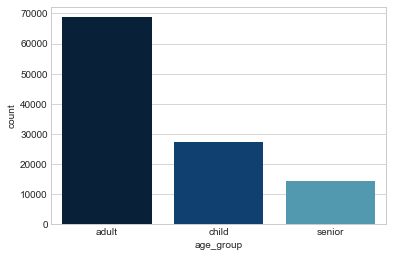

In [27]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="age_group", data=raw_data, palette="ocean")
plt.show()

In [28]:
raw_data["neighborhood"].describe()

count             110516
unique                81
top       JARDIM CAMBURI
freq                7717
Name: neighborhood, dtype: object

In [29]:
raw_data["neighborhood"].value_counts().head(n=20)

JARDIM CAMBURI       7717
MARIA ORTIZ          5805
RESISTÊNCIA          4430
JARDIM DA PENHA      3877
ITARARÉ              3514
CENTRO               3334
TABUAZEIRO           3131
SANTA MARTHA         3131
JESUS DE NAZARETH    2853
BONFIM               2773
SANTO ANTÔNIO        2744
SANTO ANDRÉ          2571
CARATOÍRA            2565
JABOUR               2509
SÃO PEDRO            2448
ILHA DO PRÍNCIPE     2266
NOVA PALESTINA       2264
ANDORINHAS           2258
DA PENHA             2217
ROMÃO                2214
Name: neighborhood, dtype: int64

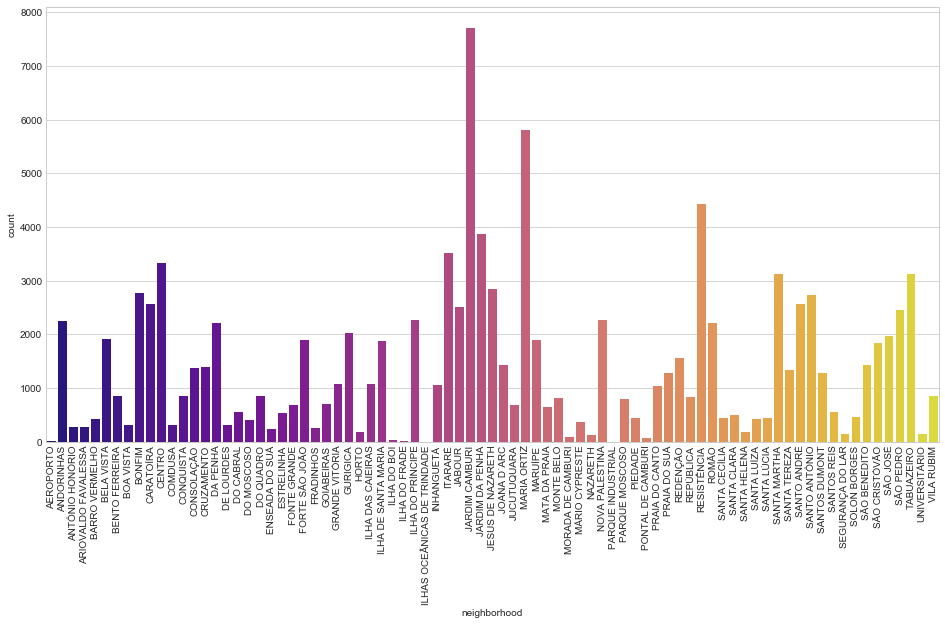

In [30]:
fig = plt.figure(figsize=(16, 8))
sns.countplot(x="neighborhood", data=raw_data, palette="plasma")
plt.xticks(rotation=90)
plt.show()

In [31]:
# Create neighborhood aggregates
neighborhood_count = pd.DataFrame(raw_data.groupby("neighborhood").count()["no_show"])
neighborhood_count.columns = ["appointment_count"]
neighborhood_count.head()

,appointment_count
neighborhood,
AEROPORTO,8
ANDORINHAS,2258
ANTÔNIO HONÓRIO,271
ARIOVALDO FAVALESSA,282
BARRO VERMELHO,423


In [32]:
neighborhood_group_names = ["very low volume", "low volume", "moderate volume", "high volume", "very high volume"]
neighborhood_count["neighborhood_volumes"] = pd.qcut(neighborhood_count["appointment_count"],
                                                     5, neighborhood_group_names)
neighborhood_count.head()

,appointment_count,neighborhood_volumes
neighborhood,,
AEROPORTO,8,very low volume
ANDORINHAS,2258,high volume
ANTÔNIO HONÓRIO,271,very low volume
ARIOVALDO FAVALESSA,282,very low volume
BARRO VERMELHO,423,low volume


In [33]:
neighborhood_count.loc["JARDIM CAMBURI", "neighborhood_volumes"]
raw_data["neighborhood_volumes"] = raw_data["neighborhood"].apply(lambda x: neighborhood_count.loc[x, "neighborhood_volumes"]).astype("category")
raw_data["neighborhood_volumes"].describe()

count               110516
unique                   5
top       very high volume
freq                 55668
Name: neighborhood_volumes, dtype: object

In [34]:
raw_data["neighborhood_volumes"].value_counts()

very high volume    55668
high volume         29558
moderate volume     15392
low volume           7541
very low volume      2357
Name: neighborhood_volumes, dtype: int64

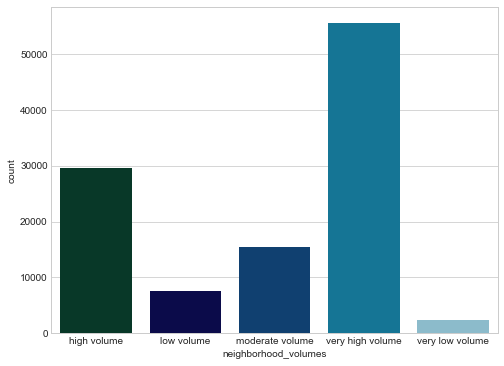

In [35]:
fig = plt.figure(figsize=(8, 6))
sns.countplot(x="neighborhood_volumes", data=raw_data, palette="ocean")
plt.show()

In [36]:
raw_data["scholarship"].describe()

count     110516
unique         2
top            0
freq       99655
Name: scholarship, dtype: int64

In [37]:
raw_data["scholarship"].value_counts()

0    99655
1    10861
Name: scholarship, dtype: int64

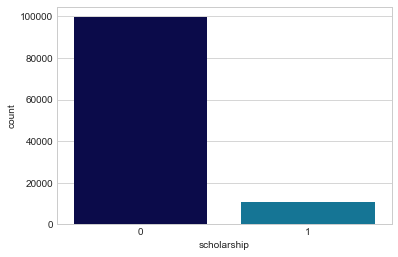

In [38]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="scholarship", data=raw_data, palette="ocean")
plt.show()

In [39]:
raw_data["hypertension"].describe()

count     110516
unique         2
top            0
freq       88716
Name: hypertension, dtype: int64

In [40]:
raw_data["hypertension"].value_counts()

0    88716
1    21800
Name: hypertension, dtype: int64

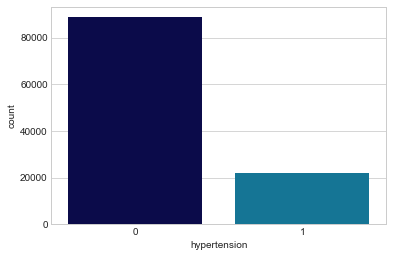

In [41]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="hypertension", data=raw_data, palette="ocean")
plt.show()

In [42]:
raw_data["diabetes"].describe()

count     110516
unique         2
top            0
freq      102573
Name: diabetes, dtype: int64

In [43]:
raw_data["diabetes"].value_counts()

0    102573
1      7943
Name: diabetes, dtype: int64

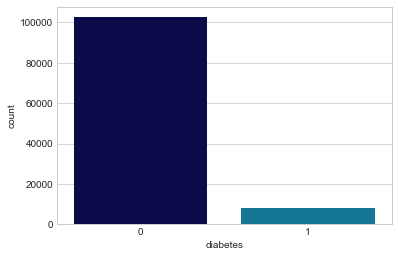

In [44]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="diabetes", data=raw_data, palette="ocean")
plt.show()

In [45]:
raw_data["alcoholism"].describe()

count     110516
unique         2
top            0
freq      107156
Name: alcoholism, dtype: int64

In [46]:
raw_data["alcoholism"].value_counts()

0    107156
1      3360
Name: alcoholism, dtype: int64

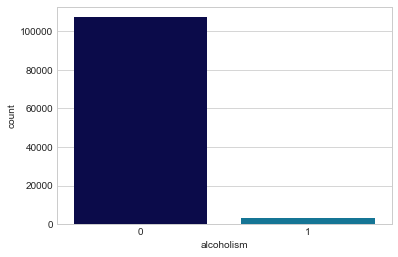

In [47]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="alcoholism", data=raw_data, palette="ocean")
plt.show()

In [48]:
raw_data["handicap"].describe()

count     110516
unique         5
top            0
freq      108281
Name: handicap, dtype: int64

In [49]:
raw_data["handicap"].value_counts()

0    108281
1      2036
2       183
3        13
4         3
Name: handicap, dtype: int64

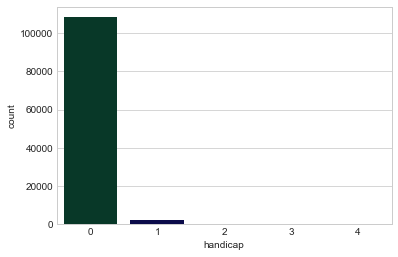

In [50]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="handicap", data=raw_data, palette="ocean")
plt.show()

In [51]:
raw_data["handicap"] = raw_data["handicap"].apply(lambda x: 0 if x == 0 else 1).astype("category")
raw_data["handicap"].value_counts()

0    108281
1      2235
Name: handicap, dtype: int64

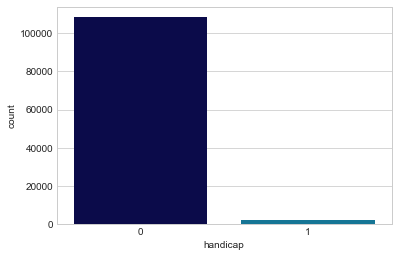

In [52]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="handicap", data=raw_data, palette="ocean")
plt.show()

In [53]:
raw_data["sms_received"].describe()

count     110516
unique         2
top            0
freq       75035
Name: sms_received, dtype: int64

In [54]:
raw_data["sms_received"].value_counts()

0    75035
1    35481
Name: sms_received, dtype: int64

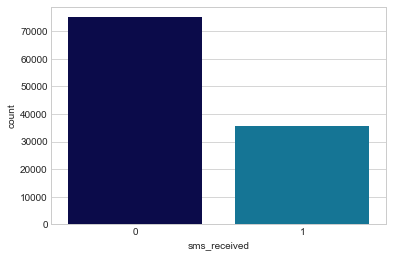

In [55]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="sms_received", data=raw_data, palette="ocean")
plt.show()

In [56]:
raw_data["no_show"].describe()

count     110516
unique         2
top           No
freq       88205
Name: no_show, dtype: object

In [57]:
raw_data["no_show"].value_counts()

No     88205
Yes    22311
Name: no_show, dtype: int64

In [58]:
# Change "No" to 0, and "Yes" to 1
raw_data["no_show"] = raw_data["no_show"].apply(lambda x: 0 if x == "No" else 1).astype("category")
raw_data["no_show"].value_counts()

0    88205
1    22311
Name: no_show, dtype: int64

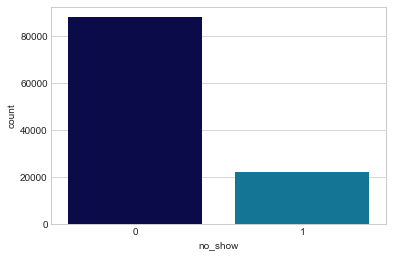

In [59]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="no_show", data=raw_data, palette="ocean")
plt.show()

### Multivariate exploration

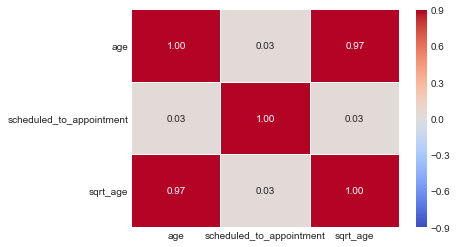

In [60]:
corr_mat = raw_data.corr()
corr_mat

sns.heatmap(data=corr_mat, vmax=0.9, vmin=-0.9, annot=True, cmap="coolwarm",fmt='.2f', linewidths=.05)
plt.show()

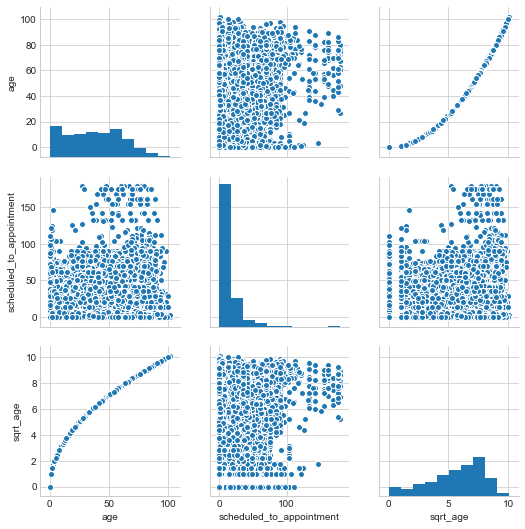

In [61]:
sns.pairplot(data=raw_data[["age", "scheduled_to_appointment", "sqrt_age"]])
plt.show()

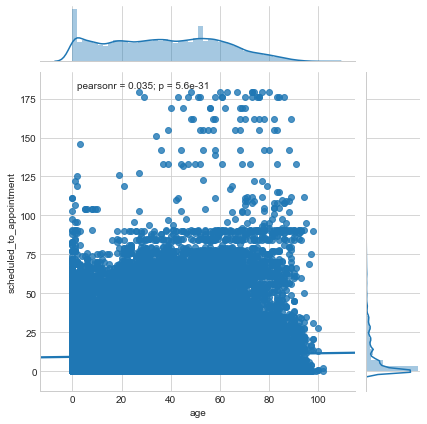

In [62]:
sns.jointplot(x="age", y="scheduled_to_appointment", data=raw_data, kind="reg")
plt.show()

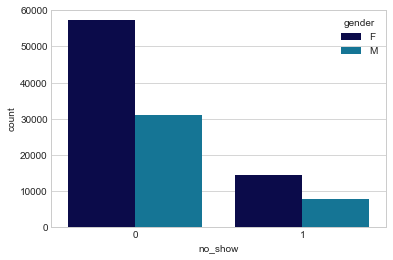

In [63]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="no_show", hue="gender", data=raw_data, palette="ocean")
plt.show()

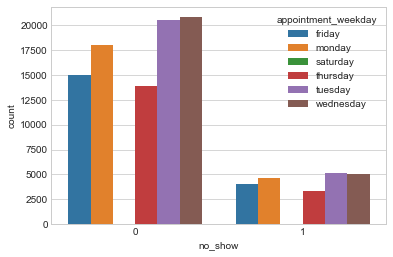

In [64]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="no_show", hue="appointment_weekday", data=raw_data)
plt.show()

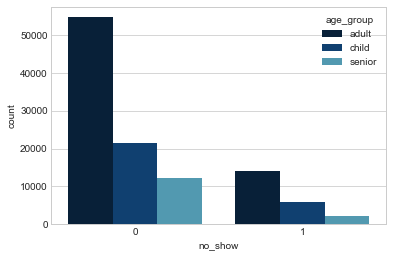

In [65]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="no_show", hue="age_group", data=raw_data, palette="ocean")
plt.show()

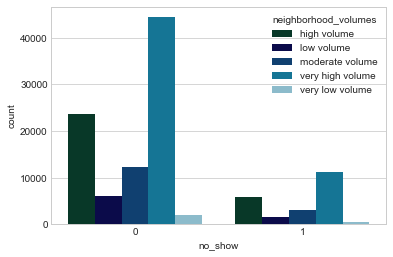

In [66]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="no_show", hue="neighborhood_volumes", data=raw_data, palette="ocean")
plt.show()

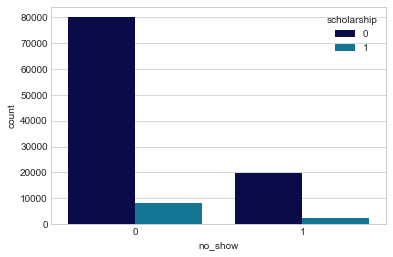

In [67]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="no_show", hue="scholarship", data=raw_data, palette="ocean")
plt.show()

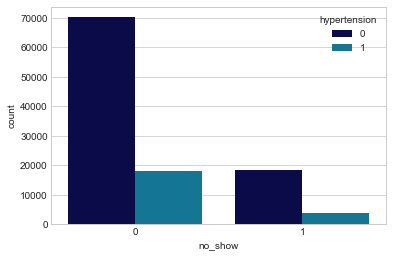

In [68]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="no_show", hue="hypertension", data=raw_data, palette="ocean")
plt.show()

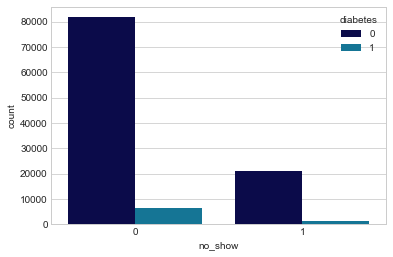

In [69]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="no_show", hue="diabetes", data=raw_data, palette="ocean")
plt.show()

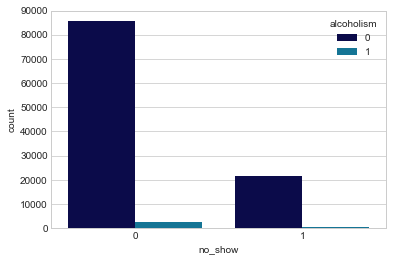

In [70]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="no_show", hue="alcoholism", data=raw_data, palette="ocean")
plt.show()

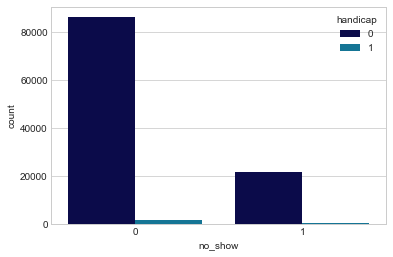

In [71]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="no_show", hue="handicap", data=raw_data, palette="ocean")
plt.show()

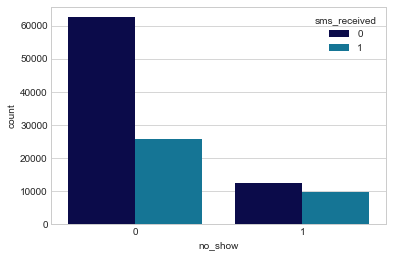

In [72]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="no_show", hue="sms_received", data=raw_data, palette="ocean")
plt.show()

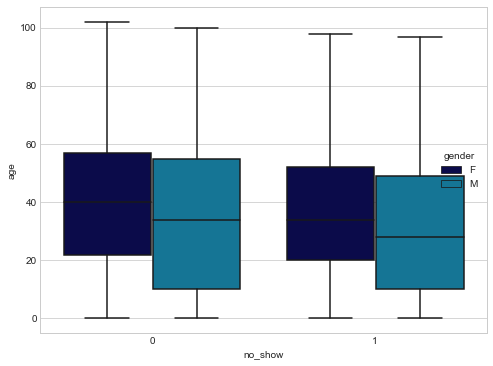

In [73]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(x="no_show", y="age", hue="gender", data=raw_data, palette="ocean")
plt.show()

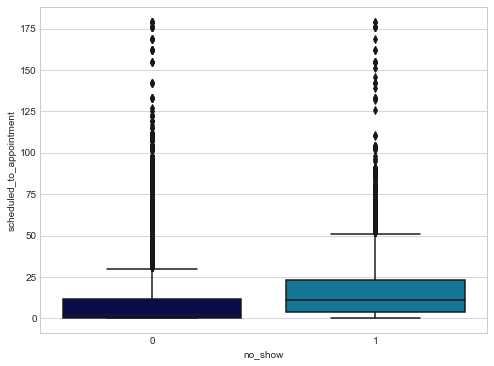

In [74]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(x="no_show", y="scheduled_to_appointment", data=raw_data, palette="ocean")
plt.show()

In [75]:
raw_data["scheduled_to_appointment"].describe()

count    110516.000000
mean         10.184272
std          15.255201
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: scheduled_to_appointment, dtype: float64

In [76]:
iqr = raw_data["scheduled_to_appointment"].describe()["75%"] - raw_data["scheduled_to_appointment"].describe()["25%"]
upper_outliers = 1.5 * iqr
upper_outliers

22.5

In [77]:
sans_outliers = raw_data[raw_data["scheduled_to_appointment"] < upper_outliers]
sans_outliers["scheduled_to_appointment"].describe()

count    92815.000000
mean         4.778096
std          6.199357
min          0.000000
25%          0.000000
50%          2.000000
75%          7.000000
max         22.000000
Name: scheduled_to_appointment, dtype: float64

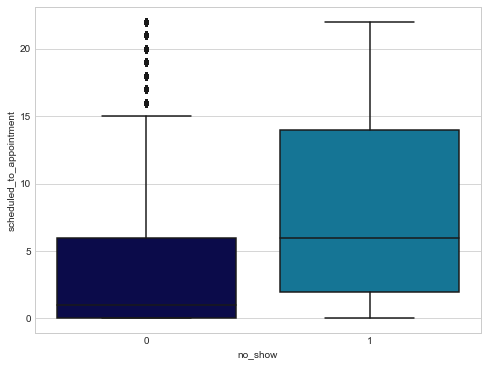

In [78]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(x="no_show", y="scheduled_to_appointment", data=sans_outliers, palette="ocean")
plt.show()

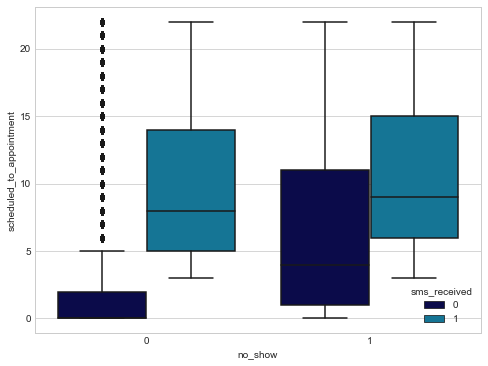

In [79]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(x="no_show", y="scheduled_to_appointment", hue="sms_received", data=sans_outliers, palette="ocean")
plt.show()

In [80]:
raw_data["same_day_appointment"] = raw_data["scheduled_to_appointment"].apply(lambda x: 1 if x == 0 else 0).astype("category")
raw_data["same_day_appointment"].describe()

count     110516
unique         2
top            0
freq       71955
Name: same_day_appointment, dtype: int64

In [81]:
raw_data["same_day_appointment"].value_counts()

0    71955
1    38561
Name: same_day_appointment, dtype: int64

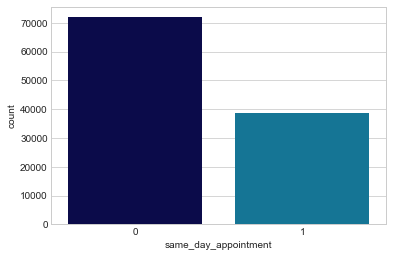

In [82]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="same_day_appointment", data=raw_data, palette="ocean")
plt.show()

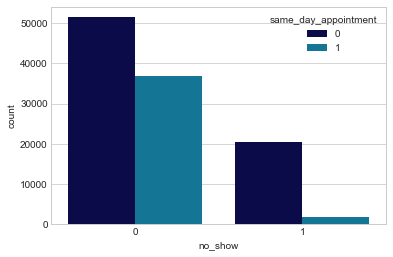

In [83]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="no_show", hue="same_day_appointment", data=raw_data, palette="ocean")
plt.show()

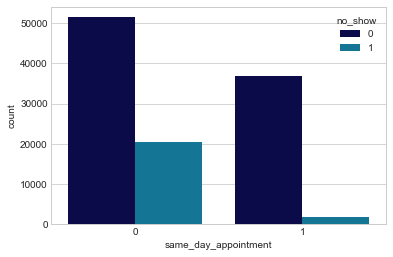

In [84]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(x="same_day_appointment", hue="no_show", data=raw_data, palette="ocean")
plt.show()

In [85]:
raw_data[raw_data["same_day_appointment"] == 1]["no_show"].value_counts(normalize=True)

0    0.953528
1    0.046472
Name: no_show, dtype: float64

In [86]:
raw_data[raw_data["same_day_appointment"] == 0]["no_show"].value_counts(normalize=True)

0    0.714836
1    0.285164
Name: no_show, dtype: float64

## Model preperation

In [106]:
features = raw_data[["gender", "age_group", "scholarship", "hypertension", "diabetes", "alcoholism",
                     "handicap", "sms_received", "neighborhood_volumes", "appointment_weekday",
                    "scheduled_to_appointment", "same_day_appointment"]]
target = raw_data["no_show"]
features = pd.get_dummies(features, drop_first=True)
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110516 entries, 0 to 110526
Data columns (total 20 columns):
scheduled_to_appointment                 110516 non-null int64
gender_M                                 110516 non-null uint8
age_group_child                          110516 non-null uint8
age_group_senior                         110516 non-null uint8
scholarship_1                            110516 non-null uint8
hypertension_1                           110516 non-null uint8
diabetes_1                               110516 non-null uint8
alcoholism_1                             110516 non-null uint8
handicap_1                               110516 non-null uint8
sms_received_1                           110516 non-null uint8
neighborhood_volumes_low volume          110516 non-null uint8
neighborhood_volumes_moderate volume     110516 non-null uint8
neighborhood_volumes_very high volume    110516 non-null uint8
neighborhood_volumes_very low volume     110516 non-null uint8
appoint

In [107]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.10)

## Run models: First Pass (no tuning)

In [108]:
def run_model(model, results, X_train, y_train, X_test, y_test, cv=10):
    start_time = time.time()
    mod = model
    results["model"].append(str(mod.__class__).split(".")[-1])
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    
    acc_scores = cross_val_score(mod, X_train, y_train, cv=cv)
    results["mean_acc_score"].append(np.mean(acc_scores))
    results["std_acc_score"].append(np.std(acc_scores))
    conf_mat = confusion_matrix(y_test, y_pred)
    results["true_positives"].append(conf_mat[0, 0])
    results["true_negatives"].append(conf_mat[1, 1])
    results["false_postives"].append(conf_mat[0, 1])
    results["false_negatives"].append(conf_mat[1, 0])
    results["precision"].append(precision_score(y_test, y_pred))
    results["recall"].append(recall_score(y_test, y_pred))
    results["f-score"].append(f1_score(y_test, y_pred))
    results["runtime"].append(time.time() - start_time)

In [109]:
#models = [SVC()]
models = [GaussianNB(), KNeighborsClassifier(), DecisionTreeClassifier(max_depth=5),
          RandomForestClassifier(n_estimators=50, max_depth=5),
          LogisticRegression(C=1000), GradientBoostingClassifier(n_estimators=500, max_depth=2, loss="deviance")]

results = {"model": [], "mean_acc_score": [], "std_acc_score": [], "true_positives": [],
           "true_negatives": [], "false_postives": [], "false_negatives": [],
           "precision": [], "recall": [], "f-score": [], "runtime": []}

In [110]:
# Base accuracy rate
raw_data["no_show"].value_counts(normalize=True)

0    0.79812
1    0.20188
Name: no_show, dtype: float64

In [111]:
for model in models:
    run_model(model, results, X_train, y_train, X_test, y_test, cv=10)

In [112]:
results_df = pd.DataFrame(results)
results_df = results_df[["model", "mean_acc_score", "std_acc_score", "true_positives",
           "true_negatives", "false_postives", "false_negatives", "precision",
           "recall", "f-score", "runtime"]]

In [113]:
results_df

,model,mean_acc_score,std_acc_score,true_positives,true_negatives,false_postives,false_negatives,precision,recall,f-score,runtime
0,GaussianNB'>,0.711986,0.006839,7055,858,1781,1358,0.325123,0.387184,0.353450,0.857704
1,KNeighborsClassifier'>,0.765161,0.003846,8065,394,771,1822,0.338197,0.177798,0.233067,71.336311
2,DecisionTreeClassifier'>,0.797987,0.000273,8832,6,4,2210,0.600000,0.002708,0.005391,1.320177
3,RandomForestClassifier'>,0.797967,0.000039,8836,0,0,2216,0.000000,0.000000,0.000000,14.419441
4,LogisticRegression'>,0.797867,0.000316,8833,2,3,2214,0.400000,0.000903,0.001801,3.276539
5,GradientBoostingClassifier'>,0.798007,0.000394,8831,7,5,2209,0.583333,0.003159,0.006284,213.918880


## Run models: Second Pass (undersampling, no tuning)

In [114]:
df_no_show_false = raw_data[raw_data["no_show"] == 0]
df_no_show_false["no_show"].value_counts()

0    88205
1        0
Name: no_show, dtype: int64

In [115]:
df_no_show_true = raw_data[raw_data["no_show"] == 1]
df_no_show_true["no_show"].value_counts()

1    22311
0        0
Name: no_show, dtype: int64

In [116]:
df_sample = df_no_show_false.sample(n=22311)
df_sample["no_show"].value_counts()

0    22311
1        0
Name: no_show, dtype: int64

In [117]:
df_sample = pd.concat([df_no_show_true, df_sample])
df_sample["no_show"].value_counts()

1    22311
0    22311
Name: no_show, dtype: int64

In [118]:
features = df_sample[["gender", "age_group", "scholarship", "hypertension", "diabetes", "alcoholism",
                     "handicap", "sms_received", "neighborhood_volumes", "appointment_weekday",
                    "scheduled_to_appointment", "same_day_appointment"]]
target = df_sample["no_show"]
features = pd.get_dummies(features, drop_first=True)
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44622 entries, 6 to 63834
Data columns (total 20 columns):
scheduled_to_appointment                 44622 non-null int64
gender_M                                 44622 non-null uint8
age_group_child                          44622 non-null uint8
age_group_senior                         44622 non-null uint8
scholarship_1                            44622 non-null uint8
hypertension_1                           44622 non-null uint8
diabetes_1                               44622 non-null uint8
alcoholism_1                             44622 non-null uint8
handicap_1                               44622 non-null uint8
sms_received_1                           44622 non-null uint8
neighborhood_volumes_low volume          44622 non-null uint8
neighborhood_volumes_moderate volume     44622 non-null uint8
neighborhood_volumes_very high volume    44622 non-null uint8
neighborhood_volumes_very low volume     44622 non-null uint8
appointment_weekday_mon

In [119]:
df_sample["no_show"].value_counts(normalize=True)

1    0.5
0    0.5
Name: no_show, dtype: float64

In [120]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.10)

In [121]:
results = {"model": [], "mean_acc_score": [], "std_acc_score": [], "true_positives": [],
           "true_negatives": [], "false_postives": [], "false_negatives": [],
           "precision": [], "recall": [], "f-score": [], "runtime": []}

for model in models:
    run_model(model, results, X_train, y_train, X_test, y_test, cv=10)

In [122]:
results_df_us = pd.DataFrame(results)
results_df_us = results_df_us[["model", "mean_acc_score", "std_acc_score", "true_positives",
           "true_negatives", "false_postives", "false_negatives", "precision",
           "recall", "f-score", "runtime"]]

In [123]:
results_df_us

,model,mean_acc_score,std_acc_score,true_positives,true_negatives,false_postives,false_negatives,precision,recall,f-score,runtime
0,GaussianNB'>,0.663861,0.009265,1214,1786,991,472,0.643140,0.790965,0.709434,0.355459
1,KNeighborsClassifier'>,0.630718,0.010090,1320,1486,885,772,0.626740,0.658105,0.642039,8.450445
2,DecisionTreeClassifier'>,0.671754,0.008960,1134,1867,1071,391,0.635466,0.826838,0.718630,0.511926
3,RandomForestClassifier'>,0.670982,0.008120,959,2045,1246,213,0.621392,0.905669,0.737070,5.742868
4,LogisticRegression'>,0.670684,0.008609,1044,1959,1161,299,0.627885,0.867582,0.728524,1.388740
5,GradientBoostingClassifier'>,0.671331,0.009493,1087,1941,1118,317,0.634521,0.859610,0.730111,75.244886


## Run models: Second Pass (oversampling, no tuning)

In [137]:
df_no_show_false = raw_data[raw_data["no_show"] == 0]
df_no_show_true = raw_data[raw_data["no_show"] == 1]

df_sample_over = pd.concat([df_no_show_false, df_no_show_true, df_no_show_true, df_no_show_true, df_no_show_true])
df_sample_over["no_show"].value_counts()

1    89244
0    88205
Name: no_show, dtype: int64

In [139]:
features = df_sample_over[["gender", "age_group", "scholarship", "hypertension", "diabetes", "alcoholism",
                     "handicap", "sms_received", "neighborhood_volumes", "appointment_weekday",
                    "scheduled_to_appointment", "same_day_appointment"]]
target = df_sample_over["no_show"]
features = pd.get_dummies(features, drop_first=True)
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177449 entries, 0 to 110516
Data columns (total 20 columns):
scheduled_to_appointment                 177449 non-null int64
gender_M                                 177449 non-null uint8
age_group_child                          177449 non-null uint8
age_group_senior                         177449 non-null uint8
scholarship_1                            177449 non-null uint8
hypertension_1                           177449 non-null uint8
diabetes_1                               177449 non-null uint8
alcoholism_1                             177449 non-null uint8
handicap_1                               177449 non-null uint8
sms_received_1                           177449 non-null uint8
neighborhood_volumes_low volume          177449 non-null uint8
neighborhood_volumes_moderate volume     177449 non-null uint8
neighborhood_volumes_very high volume    177449 non-null uint8
neighborhood_volumes_very low volume     177449 non-null uint8
appoint

In [140]:
df_sample_over["no_show"].value_counts(normalize=True)

1    0.502928
0    0.497072
Name: no_show, dtype: float64

In [141]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.10)

In [142]:
results = {"model": [], "mean_acc_score": [], "std_acc_score": [], "true_positives": [],
           "true_negatives": [], "false_postives": [], "false_negatives": [],
           "precision": [], "recall": [], "f-score": [], "runtime": []}

for model in models:
    run_model(model, results, X_train, y_train, X_test, y_test, cv=10)
    
results_df_os = pd.DataFrame(results)
results_df_os = results_df_os[["model", "mean_acc_score", "std_acc_score", "true_positives",
           "true_negatives", "false_postives", "false_negatives", "precision",
           "recall", "f-score", "runtime"]]

In [145]:
results_df_os

,model,mean_acc_score,std_acc_score,true_positives,true_negatives,false_postives,false_negatives,precision,recall,f-score,runtime
0,GaussianNB'>,0.663333,0.003089,4659,7224,4171,1691,0.633962,0.810320,0.711374,1.380204
1,KNeighborsClassifier'>,0.676282,0.004702,5593,6591,3237,2324,0.670635,0.739316,0.703303,123.382290
2,DecisionTreeClassifier'>,0.672457,0.003888,4026,7940,4804,975,0.623038,0.890634,0.733183,2.370675
3,RandomForestClassifier'>,0.670396,0.003344,3726,8198,5104,717,0.616298,0.919574,0.737993,24.847540
4,LogisticRegression'>,0.670240,0.003775,4129,7786,4701,1129,0.623528,0.873360,0.727596,6.227459
5,GradientBoostingClassifier'>,0.672870,0.003540,4269,7717,4561,1198,0.628523,0.865620,0.728259,382.974552


In [ ]:
# That's not right